# CNN

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load data
data = pd.read_csv("google_play_reviews.csv")

# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        words = word_tokenize(text)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        cleaned_text = ' '.join(words)
        return cleaned_text
    else:
        return ''

data['Tidy_Reviews'] = data['OriginalTweet'].apply(preprocess_text)

def convert_text_to_numerical(text):
    unique_words = len(set(' '.join(data['Tidy_Reviews']).split()))
    num_words = min(7000, unique_words)
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    sequence_lengths = [len(seq) for seq in sequences]
    average_length = int(sum(sequence_lengths) / len(sequence_lengths))
    maxlen = min(140, average_length * 2)
    pad_seqs = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return pad_seqs, tokenizer, maxlen  # Include maxlen in the return values

data = data.reset_index()
numeric_tweets, tokenizer, maxlen = convert_text_to_numerical(data['Tidy_Reviews'])
data.insert(len(data.columns)-1, "numeric_tweets", numeric_tweets.tolist())

label_encoder = LabelEncoder()
data.insert(len(data.columns), "encoded_labels", label_encoder.fit_transform(data['Sentiment']))

# Splitting the dataset
inputs = data[['numeric_tweets']]
outputs = data[['encoded_labels']]

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, shuffle=True, random_state=42)

X_train = np.asarray(X_train['numeric_tweets'].tolist(), dtype=np.int32)
X_test = np.asarray(X_test['numeric_tweets'].tolist(), dtype=np.int32)
y_train = np.asarray(y_train['encoded_labels'].tolist(), dtype=np.int32)
y_test = np.asarray(y_test['encoded_labels'].tolist(), dtype=np.int32)

# Building the CNN model
model1 = Sequential()
model1.add(Embedding(input_dim=num_words, output_dim=128, input_length=maxlen, trainable=True))
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(3, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

y_train_onehot = np.eye(3)[y_train]
y_test_onehot = np.eye(3)[y_test]

history1 = model1.fit(X_train, y_train_onehot, epochs=10, batch_size=1024, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.1)])

# Evaluation
predicted_labels = model1.predict(X_test, verbose=1)
predicted_classes = np.argmax(predicted_labels, axis=1)
true_classes = y_test

cnn_accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy of CNN is", cnn_accuracy)

Epoch 1/10
9/9 [==============================] - 6s 217ms/step - loss: 0.9701 - accuracy: 0.5913 - val_loss: 0.7961 - val_accuracy: 0.6126
Epoch 2/10
9/9 [==============================] - 1s 104ms/step - loss: 0.7271 - accuracy: 0.6112 - val_loss: 0.6712 - val_accuracy: 0.6126
Epoch 3/10
9/9 [==============================] - 1s 111ms/step - loss: 0.6426 - accuracy: 0.6449 - val_loss: 0.6435 - val_accuracy: 0.6126
Epoch 4/10
9/9 [==============================] - 1s 103ms/step - loss: 0.6007 - accuracy: 0.6845 - val_loss: 0.6143 - val_accuracy: 0.6667
Epoch 5/10
9/9 [==============================] - 1s 118ms/step - loss: 0.5415 - accuracy: 0.7673 - val_loss: 0.5688 - val_accuracy: 0.7077
Epoch 6/10
9/9 [==============================] - 1s 101ms/step - loss: 0.4636 - accuracy: 0.8062 - val_loss: 0.5230 - val_accuracy: 0.7467
Epoch 7/10
9/9 [==============================] - 1s 106ms/step - loss: 0.3859 - accuracy: 0.8377 - val_loss: 0.5024 - val_accuracy: 0.7648
Epoch 8/10
79/79 [==

# LSTM

In [10]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

# Load data
data = pd.read_csv("google_play_reviews.csv")

# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        words = word_tokenize(text)
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
        cleaned_text = ' '.join(words)
        return cleaned_text
    else:
        return ''

data['Tidy_Reviews'] = data['OriginalTweet'].apply(preprocess_text)

def convert_text_to_numerical(text):
    unique_words = len(set(' '.join(data['Tidy_Reviews']).split()))
    num_words = min(7000, unique_words)
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    sequence_lengths = [len(seq) for seq in sequences]
    average_length = int(sum(sequence_lengths) / len(sequence_lengths))
    maxlen = min(140, average_length * 2)
    pad_seqs = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return pad_seqs, tokenizer, maxlen  # Include maxlen in the return values

data = data.reset_index()
numeric_tweets, tokenizer, maxlen = convert_text_to_numerical(data['Tidy_Reviews'])
data.insert(len(data.columns)-1, "numeric_tweets", numeric_tweets.tolist())

label_encoder = LabelEncoder()
data.insert(len(data.columns), "encoded_labels", label_encoder.fit_transform(data['Sentiment']))

# Splitting the dataset
inputs = data[['numeric_tweets']]
outputs = data[['encoded_labels']]

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, shuffle=True, random_state=42)

X_train = np.asarray(X_train['numeric_tweets'].tolist(), dtype=np.int32)
X_test = np.asarray(X_test['numeric_tweets'].tolist(), dtype=np.int32)
y_train = np.asarray(y_train['encoded_labels'].tolist(), dtype=np.int32)
y_test = np.asarray(y_test['encoded_labels'].tolist(), dtype=np.int32)

# Load pre-trained word embeddings
embedding_dim = 100
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix for the tokenizer
word_index = tokenizer.word_index
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert the output labels to one-hot encoded vectors
y_train_en = to_categorical(y_train)
y_test_en = to_categorical(y_test)

# Create the model
model2 = Sequential()
model2.add(Embedding(num_words, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=True))
model2.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model2.add(Dense(2, activation='softmax'))

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history2 = model2.fit(X_train, y_train_en, epochs=10, batch_size=1024, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

# Evaluation
predicted_labels = model2.predict(X_test, verbose=1)
predicted_classes = np.argmax(predicted_labels, axis=1)
true_classes = y_test

LSTM_accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy of LSTM is", LSTM_accuracy)


Epoch 1/10
9/9 [==============================] - 12s 645ms/step - loss: 0.6826 - accuracy: 0.5965 - val_loss: 0.6613 - val_accuracy: 0.6386
Epoch 2/10
9/9 [==============================] - 5s 558ms/step - loss: 0.6529 - accuracy: 0.6288 - val_loss: 0.6238 - val_accuracy: 0.6587
Epoch 3/10
9/9 [==============================] - 6s 658ms/step - loss: 0.5996 - accuracy: 0.6695 - val_loss: 0.5278 - val_accuracy: 0.7437
Epoch 4/10
9/9 [==============================] - 6s 639ms/step - loss: 0.5285 - accuracy: 0.7406 - val_loss: 0.4869 - val_accuracy: 0.7718
Epoch 5/10
9/9 [==============================] - 6s 697ms/step - loss: 0.4878 - accuracy: 0.7653 - val_loss: 0.4837 - val_accuracy: 0.7828
Epoch 6/10
9/9 [==============================] - 7s 807ms/step - loss: 0.4669 - accuracy: 0.7820 - val_loss: 0.4630 - val_accuracy: 0.7848
Epoch 7/10
9/9 [==============================] - 6s 709ms/step - loss: 0.4526 - accuracy: 0.7895 - val_loss: 0.4691 - val_accuracy: 0.7928
Epoch 8/10
9/9 [===

In [11]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

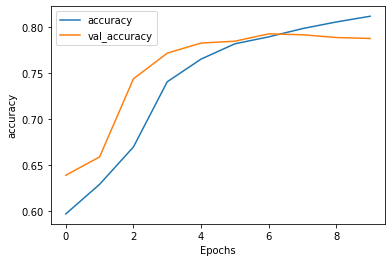

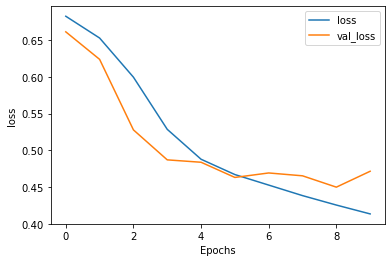

In [12]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

# SVM

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

data = pd.read_csv("google_play_reviews.csv")

def remove_pattern(text,pattern):
    r = re.findall(pattern,text)
    for i in r:
        text = re.sub(i,"",text)
    
    return text

data['text_clean'] = np.vectorize(remove_pattern)(data['OriginalTweet'], "@[\w]*")
data['text_clean'] = data['text_clean'].str.replace("[^a-zA-Z#]", " ")
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

data.rename(columns = {'Sentiment':'sentiment'}, inplace = True)

data_clean = data.loc[:, ['text_clean', 'sentiment']]

train, test = train_test_split(data_clean, test_size=0.2, random_state=1)
X_train = train['text_clean'].values
X_test = test['text_clean'].values
y_train = train['sentiment']
y_test = test['sentiment']

def tokenize(text): 
    tknzr = TweetTokenizer()
    return tknzr.tokenize(text)

def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

en_stopwords = set(stopwords.words("english")) 

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = en_stopwords)

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(X_train, y_train)
grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.8352130103572091

In [12]:
grid_svm.best_params_

{'svc__C': 0.1}

In [13]:
grid_svm.best_score_

0.8413742205297741

In [15]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

report_results(grid_svm.best_estimator_, X_test, y_test)

{'auc': 0.8352119871871828,
 'f1': 0.7026496565260059,
 'acc': 0.7573087705246295,
 'precision': 0.6544789762340036,
 'recall': 0.7584745762711864}

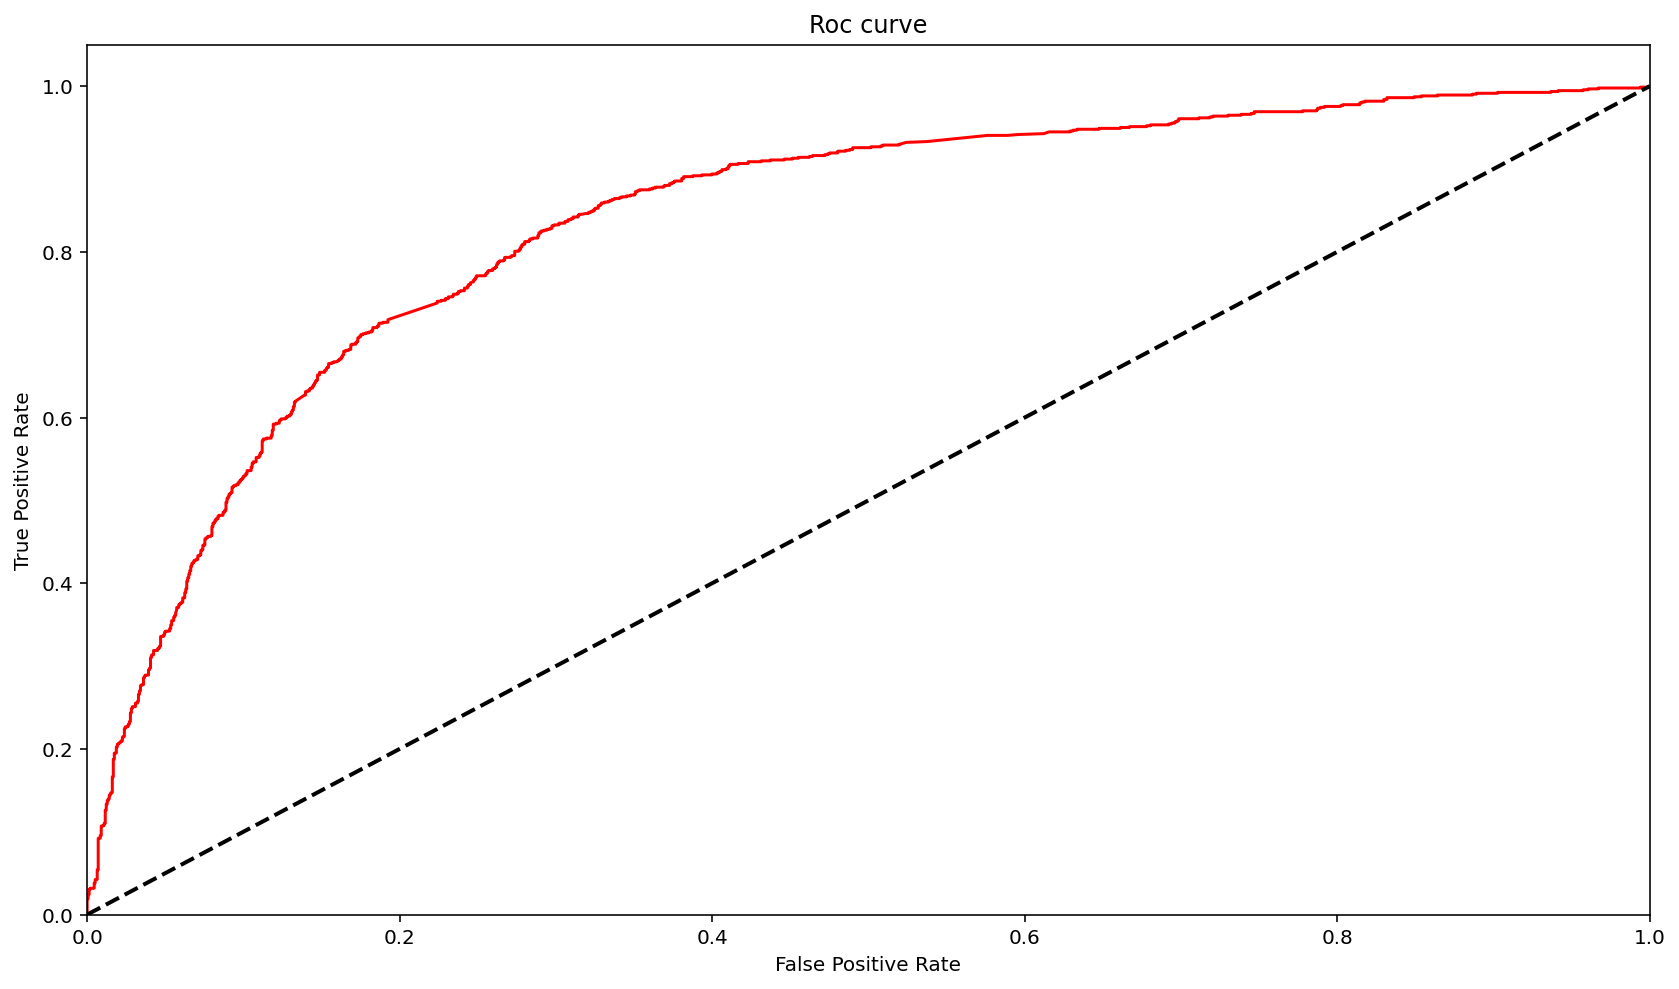

In [18]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

roc_svm = get_roc_curve(grid_svm.best_estimator_, X_test, y_test)

fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

# Deep Learning (Baseline Model)

In [27]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

df = pd.read_csv('google_play_reviews.csv')

df.rename(columns = {'OriginalTweet':'text', 'Sentiment':'airline_sentiment'}, inplace = True)

df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]

def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 11236 documents
10000 words in dictionary
Top 5 most common words are: [('app', 6841), ('not', 2581), ('it', 2216), ('good', 1566), ('like', 1560)]


In [29]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[73, 81, 5717]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 3.0 features with a value of 1.


In [31]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1124, 10000)


## Baseline model

In [35]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(2, activation='softmax'))
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640064    
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


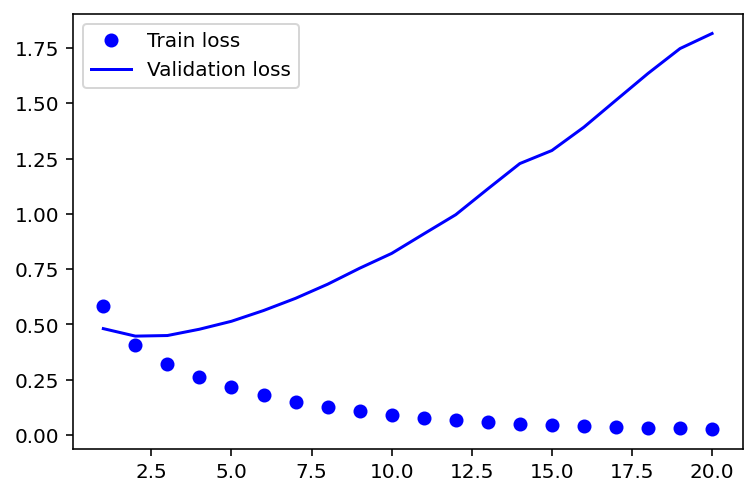

In [39]:
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

base_history = deep_model(base_model)

def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

eval_metric(base_history, 'loss')

In [42]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(2, activation='softmax'))
reduced_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                320032    
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 320,098
Trainable params: 320,098
Non-trainable params: 0
_________________________________________________________________


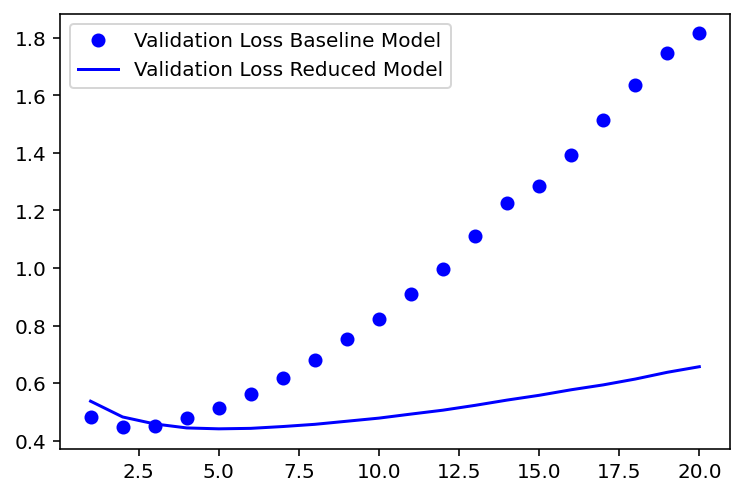

In [45]:
reduced_history = deep_model(reduced_model)

def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

compare_loss_with_baseline(reduced_history, 'Reduced Model')

In [46]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(2, activation='softmax'))
reg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                640064    
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 2)                 130       
                                                                 
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


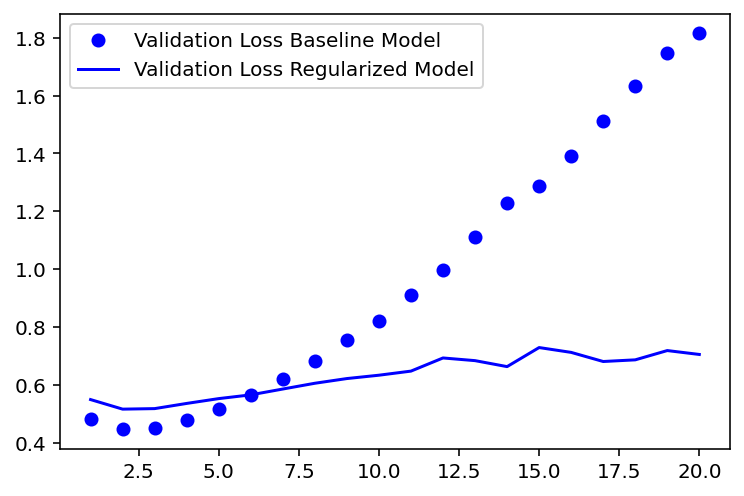

In [48]:
reg_history = deep_model(reg_model)
compare_loss_with_baseline(reg_history, 'Regularized Model')

In [49]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(2, activation='softmax'))
drop_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 2)                 130       
                                                                 
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


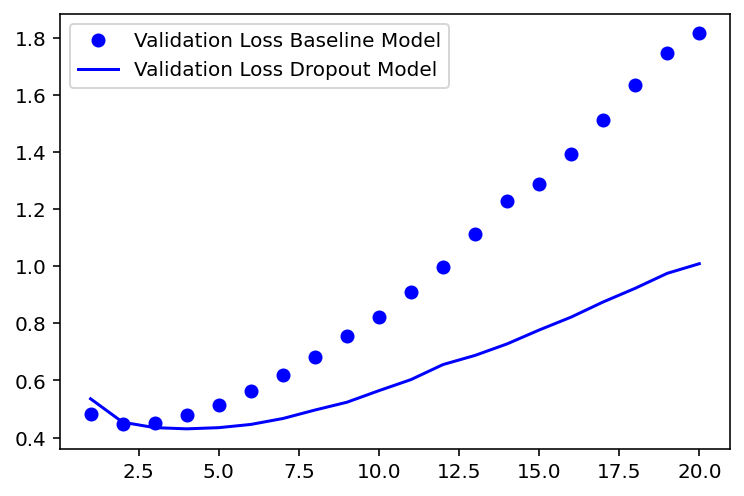

In [51]:
drop_history = deep_model(drop_model)
compare_loss_with_baseline(drop_history, 'Dropout Model')

In [52]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [53]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

40/40 [==============================] - 1s 7ms/step - loss: 1.3013 - accuracy: 0.7686
/n
Test accuracy of baseline model: 76.86%


In [54]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

40/40 [==============================] - 0s 5ms/step - loss: 0.8797 - accuracy: 0.7766
/n
Test accuracy of reduced model: 77.66%


In [55]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

40/40 [==============================] - 0s 6ms/step - loss: 0.7283 - accuracy: 0.7926
/n
Test accuracy of regularized model: 79.26%


In [56]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

40/40 [==============================] - 0s 5ms/step - loss: 1.1020 - accuracy: 0.7798
/n
Test accuracy of dropout model: 77.98%
